In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm
import corner
import copy
import multiprocessing as mp
from tqdm import tqdm
from functools import partial
import pickle

from hmc import HMC
from distributions import UnivariateNormal, IndependentMultivariateNormal, MultivariateNormal, HierarchicalBayesianLogisticRegression


plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath, amsfonts}"]

import matplotlib.lines as mlines

np.random.seed(34958)

In [2]:
# sns.set()

# Saving/Loading

In [2]:
imdir = './figures/'
datadir = './data/'

for f in [imdir, datadir]:
    if not os.path.exists(f):
        os.makedirs(f)

In [3]:
integrators = ['leapfrog', 'yoshida', 'ruth', 'calvo']

In [16]:
with open(os.path.join(datadir,'results.p'), 'wb') as f:
    pickle.dump(results, f)

In [4]:
with open(os.path.join(datadir,'results.p'), 'rb') as f:
    results = pickle.load(f)

In [ ]:
results = {}

# Setup

In [5]:
N_chains = mp.cpu_count() - 1

In [6]:
# Parameters
dts = [10**c for c in np.arange(-6, -1, dtype=float)]
Ls = np.arange(3, 8)

In [7]:
# Get data for dts
def run_dt(data,
           dist, 
           M, 
           n_args, 
           steps,
           N_chains,
           init_x,
           L=5, 
           dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
           prop='leapfrog',
           verbose=False,
           burn=0.1):
    results = {}
    times = {}
    print('Running:', dt)
    for d in dt:
        print(d)
        sampler = HMC(dist.logp, dist.dlogp, dt=d, L=L, M=M, n_args=n_args, prop=prop)
        time0 = time.time()
        xs = sampler.sample_pool(steps, data, N_chains, init_x=init_x, verbose=verbose)
        
        xs = xs[int(len(xs)*burn):]
        times[d] = time.time() - time0
        results[d] = xs
    acc_dict = {}
    for d, xs in results.items():
        acc_chain = []
        for c in range(N_chains):
            acc_chain.append(len(np.unique(xs[c], axis=0)) / xs[c].shape[0])
        acc_dict[d] = np.mean(acc_chain)
    return results, times, acc_dict

def run_L(data,
           dist, 
           M, 
           n_args, 
           steps,
           N_chains,
           init_x,
           Ls=np.arange(3, 8), 
           dt=1e-4, 
           prop='leapfrog',
           verbose=False,
           burn=0.1):
    results = {}
    times = {}
    print('Running:', Ls)
    for l in Ls:
        print(l)
        sampler = HMC(dist.logp, dist.dlogp, dt=dt, L=l, M=M, n_args=n_args, prop=prop)
        time0 = time.time()
        xs = sampler.sample_pool(steps, data, N_chains, init_x=init_x, verbose=verbose)
        
        xs = xs[int(len(xs)*burn):]
        times[l] = time.time() - time0
        results[l] = xs
    acc_dict = {}
    for l, xs in results.items():
        acc_chain = []
        for c in range(N_chains):
            acc_chain.append(len(np.unique(xs[c], axis=0)) / xs[c].shape[0])
        acc_dict[l] = np.mean(acc_chain)
    return results, times, acc_dict

In [8]:
def effective_sample_size(x, truncation=True, threshold=0.05):
    # A mapping from sample space to $R$
    # we use mean here
    M = len(x)
    if len(x.shape) > 1:
        f = x.mean(axis=-1)
    else:
        f = x
    
    # Compute mu, sigma
    mu_f = f.mean()
    var_f = f.var()
        
    ess = 0
    ro = np.zeros(M-1)
    temp = f - mu_f
    for s in range(M-1):
        ro[s] = temp[s+1:].dot(temp[:M-s-1]) / (var_f * (M-s-1))
    if truncation:
        M_cutoff = np.argmax(ro < threshold)
        ess = M / (1 + 2 * (1 - np.arange(1, M_cutoff+1) / M).dot(ro[:M_cutoff]))
    else:
        ess = M / (1 + 2 * (1 - np.arange(1, M) / M).dot(ro))
    return ess


"""
Special note: in original "No U-Turn" paper, ESS was computed
in two ways: 1. map from $R^d$ to $R$ then compute the ESS;
2. directly compute ESS on seperate dimensions
"""
def effective_sample_size_on_seperate_dimensions(x, truncation=True, threshold=0.05):
    if len(x.shape) > 1:
        res = []
        for i in range(x.shape[-1]):
            res.append(effective_sample_size(x[:, i]))
        return res
    else:
        return effective_sample_size(x, truncation, threshold)


def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size(xs[c]))
        ess[p] = np.mean(temp)
    return ess

# Sampling Example $\mathcal{N}(\mu,\sigma)$

In [ ]:
name='uni'
latex = 'Univariate Normal $\mathcal{N}(\mu,\sigma)$'

if name not in results.keys():
    results[name] = {}

In [ ]:
# Generate observed data
truth = (0,1)

N = 10000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

In [ ]:
# Initialize Distribution
dist = UnivariateNormal()

In [ ]:
for sampler in integrators:
    
    print(name, sampler)
    results[name][sampler]={}
    
    
    samples, times, acc = run_dt(data, dist, 
                                 M=0.1*np.identity(2),
                                 n_args=2, steps=10**3,
                                 N_chains=N_chains,
                                 init_x=[0.1,0.5],
                                 L=5, 
                                 dt=dts, 
                                 prop=sampler, 
                                 verbose=False
                                )
    results[name][sampler]['dt'] = (samples, times, acc)
    
    
    samples, times, acc = run_L(data, dist,
                                M=0.1*np.identity(2), 
                                n_args=2, steps=10**3,
                                N_chains=N_chains,
                                init_x=[0.1,0.5],
                                Ls=Ls,
                                dt=1e-4,
                                prop=sampler, 
                                verbose=False
                               )
    results[name][sampler]['L'] = (samples, times, acc)

In [ ]:
ylim = (1.5, 10)

f = plt.figure(figsize=(6,3))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ax1.semilogx(list(results[name][sampler]['dt'][1].keys()),
                 list(results[name][sampler]['dt'][1].values()), '-*', label=sampler)

ax1.set_xlabel('Step size $\epsilon$')
ax1.set_ylabel('Compute time(s)')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][1].keys()))
ax1.legend(ncol=2)


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ax2.plot(list(results[name][sampler]['L'][1].keys()),
             list(results[name][sampler]['L'][1].values()), '-*', label=sampler)

ax2.set_xlabel('Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][1].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex)

In [ ]:
ylim = (0, 1)

f = plt.figure(figsize=(6,3))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ax1.semilogx(list(results[name][sampler]['dt'][2].keys()),
                 list(results[name][sampler]['dt'][2].values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Acceptance Rate $\alpha$')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][2].keys()))
ax1.legend(ncol=2)


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ax2.plot(list(results[name][sampler]['L'][2].keys()),
             list(results[name][sampler]['L'][2].values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][2].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex)

In [ ]:
ylim = (0, 1000)

f = plt.figure(figsize=(6,3))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ESS = average_ess(results[name][sampler]['dt'][0])
    ax1.semilogx(list(ESS.keys()),
                 list(ESS.values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Effective Sample Size (ESS)')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][2].keys()))
ax1.legend()


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ESS = average_ess(results[name][sampler]['L'][0])
    ax2.semilogx(list(ESS.keys()),
                 list(ESS.values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][2].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex)

# Diagonal Multivariate Gaussian

In [23]:
name='Gauss'
latex = r'Independent Normal $\mathcal{N}\left(\mu,\operatorname{diag}(\Sigma)\right)$'

if name not in results.keys():
    results[name] = {}

In [24]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian
nargs = 2*ndims

# mu_tru = 10*np.random.rand(ndims)
# sig_tru = 5*np.random.rand(ndims)

N = 5000
# data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data, axis=0)}, sig_hat: {np.cov(data)}')

mu_*: [7.52462872 7.34981278 8.70268472 4.83900958 6.60557619], sig_*: [[1.97041612 0.         0.         0.         0.        ]
 [0.         3.27593955 0.         0.         0.        ]
 [0.         0.         1.29730375 0.         0.        ]
 [0.         0.         0.         0.77888176 0.        ]
 [0.         0.         0.         0.         3.06181812]]
mu_hat: [7.52513139 7.32503189 8.71765452 4.8466948  6.58255542], sig_hat: [[3.31073131 4.28182352 3.75635532 ... 2.61785947 3.26250737 2.42257963]
 [4.28182352 6.50413772 5.1029076  ... 3.0701263  3.92328558 3.77604579]
 [3.75635532 5.1029076  7.04531244 ... 5.13505058 4.28659985 5.24273856]
 ...
 [2.61785947 3.0701263  5.13505058 ... 4.04310129 3.11158879 3.67275043]
 [3.26250737 3.92328558 4.28659985 ... 3.11158879 4.11351319 2.49389494]
 [2.42257963 3.77604579 5.24273856 ... 3.67275043 2.49389494 4.30320506]]


In [10]:
with open(os.path.join(datadir,'gauss.p'), 'rb') as f:
    out = pickle.load(f)
    
mu_tru = out['mu_tru']
sig_tru = out['sig_tru']
data = out['data']

In [ ]:
out = {'mu_tru':mu_tru,
       'sig_tru':sig_tru,
       'data':data}

with open(os.path.join(datadir,'gauss.p'), 'wb') as f:
    pickle.dump(out, f)

In [13]:
# Initialize Distribution
dist = IndependentMultivariateNormal(n_dims=ndims)

In [15]:
for sampler in integrators[1:]:
    
    print(name, sampler)
#     results[name][sampler]={}
    
    
    samples, times, acc = run_dt(data, dist, 
                                 M=0.1*np.identity(nargs),
                                 n_args=nargs, steps=10**4,
                                 N_chains=N_chains,
                                 init_x=(np.concatenate([mu_tru, sig_tru])+ 0.01*np.random.normal(size=nargs)),
                                 L=5, 
                                 dt= dts, 
                                 prop=sampler, 
                                 verbose=False
                                )
    results[name][sampler]['dt'] = (samples, times, acc)
#     results[name][sampler]['dt'][0][0.01] = samples[0.01]
#     results[name][sampler]['dt'][1][0.01] = times[0.01]
#     results[name][sampler]['dt'][2][0.01] = acc[0.01]
    
    
    samples, times, acc = run_L(data, dist,
                                M=0.1*np.identity(nargs), 
                                n_args=nargs, steps=10**4,
                                N_chains=N_chains,
                                init_x=(np.concatenate([mu_tru, sig_tru])+ 0.01*np.random.normal(size=nargs)),
                                Ls=Ls,
                                dt=1e-4,
                                prop=sampler, 
                                verbose=False
                               )
    results[name][sampler]['L'] = (samples, times, acc)

Gauss yoshida
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06
1e-05
0.0001
0.001
0.01
Running: [3 4 5 6 7]
3
4
5
6
7
Gauss ruth
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06
1e-05
0.0001
0.001
0.01
Running: [3 4 5 6 7]
3
4
5
6
7
Gauss calvo
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06
1e-05
0.0001
0.001
0.01
Running: [3 4 5 6 7]
3
4
5
6
7


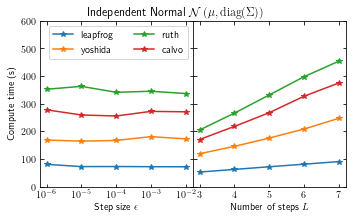

In [25]:
ylim = (0,600)

f = plt.figure(figsize=(5.,3.))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ax1.semilogx(list(results[name][sampler]['dt'][1].keys()),
                 list(results[name][sampler]['dt'][1].values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Compute time (s)')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][1].keys()))
ax1.legend(ncol=2)


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ax2.plot(list(results[name][sampler]['L'][1].keys()),
             list(results[name][sampler]['L'][1].values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][1].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex, y=1.)

plt.tight_layout()
f.savefig(imdir+name+'_time.pdf')

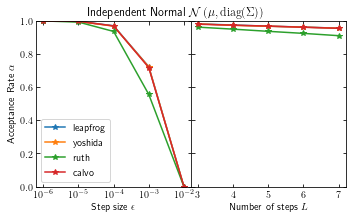

In [26]:
ylim = (0, 1)

f = plt.figure(figsize=(5,3))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ax1.semilogx(list(results[name][sampler]['dt'][2].keys()),
                 list(results[name][sampler]['dt'][2].values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Acceptance Rate $\alpha$')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][2].keys()))
ax1.legend(ncol=1)


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ax2.plot(list(results[name][sampler]['L'][2].keys()),
             list(results[name][sampler]['L'][2].values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][2].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex, y=1.)

plt.tight_layout()
f.savefig(imdir+name+'_acc.pdf')

In [47]:
def effective_sample_size(x, truncation=True, threshold=0.05):
    # A mapping from sample space to $R$
    # we use mean here
    M = len(x)
    if len(x.shape) > 1:
        f = x.mean(axis=0)
    else:
        f = x
    
    # Compute mu, sigma
    mu_f = f.mean()
    var_f = f.var()
        
    ess = 0
    ro = np.zeros(M-1)
    temp = f - mu_f
    for s in range(M-1):
        ro[s] = temp[s+1:].dot(temp[:M-s-1]) / (var_f * (M-s-1))
    if truncation:
        M_cutoff = np.argmax(ro < threshold)
        ess = M / (1 + 2 * (1 - np.arange(1, M_cutoff+1) / M).dot(ro[:M_cutoff]))
    else:
        ess = M / (1 + 2 * (1 - np.arange(1, M) / M).dot(ro))
    return ess


"""
Special note: in original "No U-Turn" paper, ESS was computed
in two ways: 1. map from $R^d$ to $R$ then compute the ESS;
2. directly compute ESS on seperate dimensions
"""
def effective_sample_size_on_seperate_dimensions(x, truncation=True, threshold=0.05):
    if len(x.shape) > 1:
        res = []
        for i in range(x.shape[-1]):
            res.append(effective_sample_size(x[:, i]))
        return res
    else:
        return effective_sample_size(x, truncation, threshold)


def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size(xs[c]))
        ess[p] = np.mean(temp)
    return ess

/Users/maho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/maho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


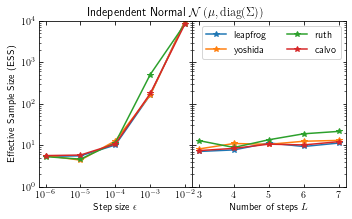

In [27]:
ylim = (1, 10000)

f = plt.figure(figsize=(5.,3.))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ESS = average_ess(results[name][sampler]['dt'][0])
    ax1.loglog(list(ESS.keys()),
                 list(ESS.values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Effective Sample Size (ESS)')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][2].keys()))
# ax1.legend()


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ESS = average_ess(results[name][sampler]['L'][0])
    ax2.semilogy(list(ESS.keys()),
                 list(ESS.values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][2].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex, y=1.)

plt.tight_layout()
f.savefig(imdir+name+'_ess.pdf')

<Figure size 720x720 with 0 Axes>

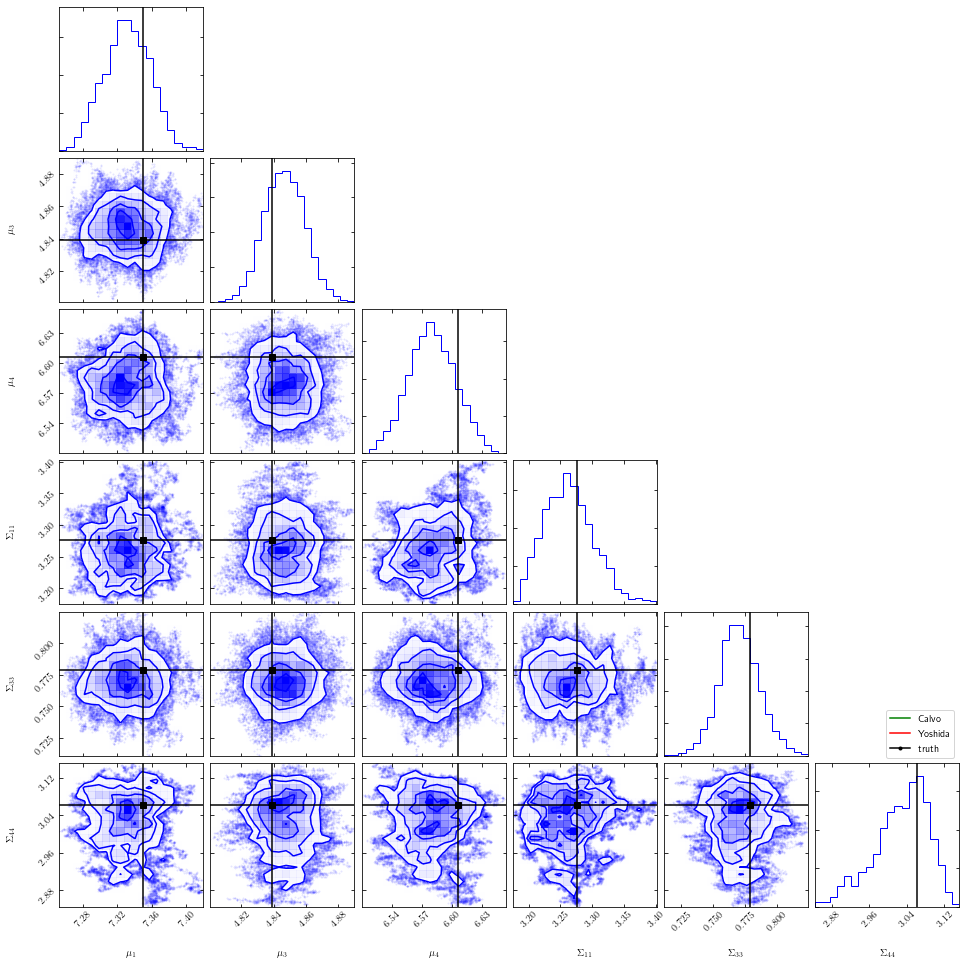

In [20]:
f = plt.figure(figsize=(10.,10.))
gs = mpl.gridspec.GridSpec(2,2, wspace=0)

sel = [1,3,4,6,8,9]
# Corner plot
f = corner.corner(results[name][integrators[0]]['L'][0][5][:,2000:].reshape(-1,nargs)[:,sel], 
                  labels=np.array([f'$\mu_{{{i}}}$' for i in range(ndims)] + 
                                  [f'$\Sigma_{{{i}{i}}}$' for i in range(ndims)])[sel],
                  truths=np.concatenate([mu_tru, sig_tru])[sel],
                  color='b', truth_color='k')

for sampler in integrators[1:1]:
    corner.corner(results[name][sampler]['L'][0][5][:,2000:].reshape(-1,nargs)[:,sel], 
                  fig=f, color='g')

b = mlines.Line2D([], [], color='blue', label='Leapfrog')
r = mlines.Line2D([], [], color='red', label='Yoshida')
b = mlines.Line2D([], [], color='green', label='Calvo')
t = mlines.Line2D([], [], marker='.',color='k', label='truth')

plt.legend(handles=[b,r,t], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig(imdir+name+'_cornerfull.pdf')

<Figure size 720x720 with 0 Axes>

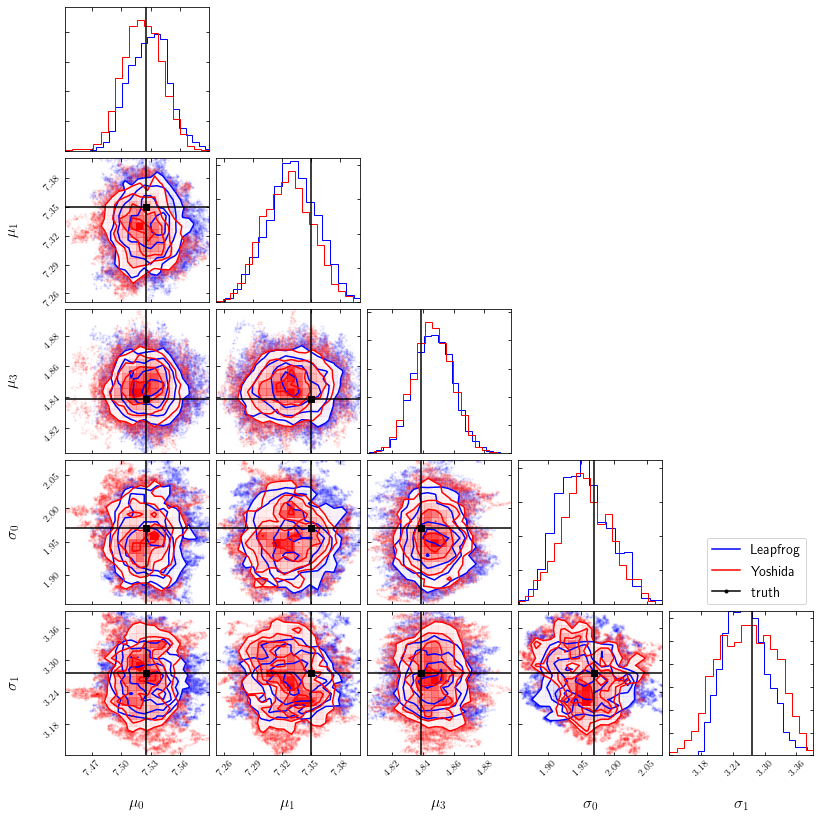

In [25]:
f = plt.figure(figsize=(10.,10.))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0)

sel = [0,1,3,5,6]
# Corner plot

cs = ['b','r','g','y']
labels = np.array([f'$\mu_{i}$' for i in range(ndims)] + 
                  [f'$\sigma_{i}$' for i in range(ndims)])
# print(labels)
data = results[name][integrators[0]]['L'][0][5][:,1000:].reshape(-1,nargs)
# data = data[np.all(np.abs(data)<10, axis=1)]
f = corner.corner(data[:,sel], 
                  labels=labels[sel],
                  truths=np.concatenate([mu_tru, sig_tru])[sel],
                  color=cs[0], truth_color='k',
                  label_kwargs={'fontsize':16})
i=0
for sampler in integrators[1:2]:
    i+=1
    data = results[name][sampler]['L'][0][5][:,1000:].reshape(-1,nargs)
#     data = data[np.all(np.abs(data)<10, axis=1)]
    corner.corner(data[:,sel], 
                  fig=f, color=cs[i])
    

b = mlines.Line2D([], [], color='blue', label='Leapfrog')
r = mlines.Line2D([], [], color='red', label='Yoshida')
# b = mlines.Line2D([], [], color='green', label='Calvo')
t = mlines.Line2D([], [], marker='.',color='k', label='truth')

plt.legend(handles=[b,r,t], fontsize=14,
           bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig(imdir+name+'_cornerLY.pdf')

<Figure size 720x720 with 0 Axes>

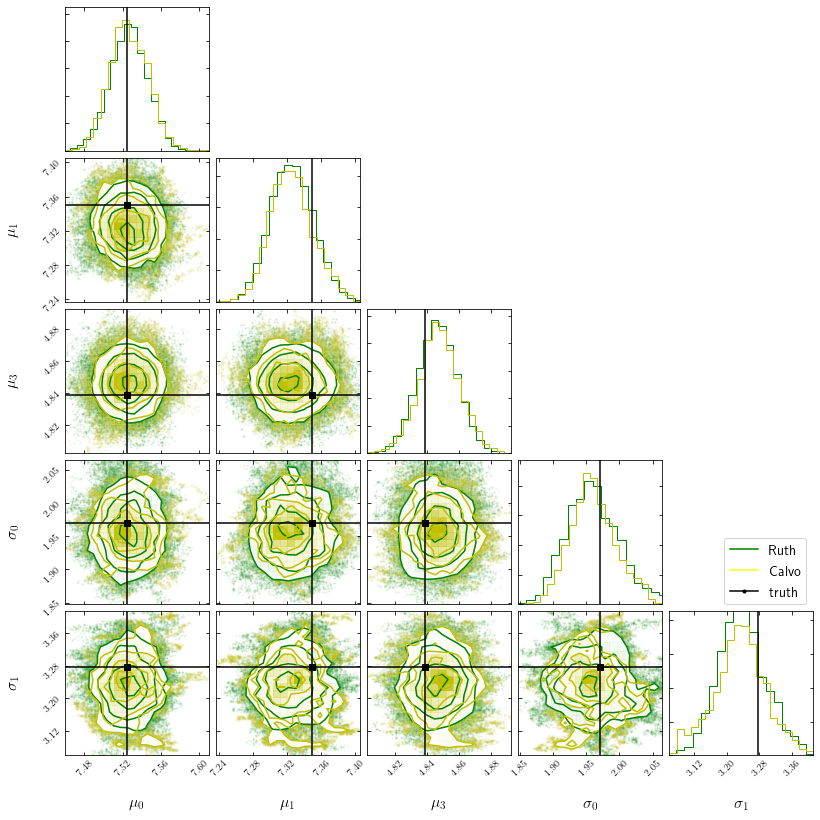

In [26]:
f = plt.figure(figsize=(10.,10.))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0)

sel = [0,1,3,5,6]
# Corner plot

cs = ['b','r','g','y']
labels = np.array([f'$\mu_{i}$' for i in range(ndims)] + 
                  [f'$\sigma_{i}$' for i in range(ndims)])
# print(labels)
data = results[name][integrators[2]]['L'][0][5][:,1000:].reshape(-1,nargs)
# data = data[np.all(np.abs(data)<10, axis=1)]
f = corner.corner(data[:,sel], 
                  labels=labels[sel],
                  truths=np.concatenate([mu_tru, sig_tru])[sel],
                  color='g', truth_color='k',
                  label_kwargs={'fontsize':16})

for sampler in integrators[3:4]:
    data = results[name][sampler]['L'][0][5][:,1000:].reshape(-1,nargs)
#     data = data[np.all(np.abs(data)<10, axis=1)]
    corner.corner(data[:,sel], 
                  fig=f, color='y')
    

# b = mlines.Line2D([], [], color='blue', label='Leapfrog')
# r = mlines.Line2D([], [], color='red', label='Yoshida')
g = mlines.Line2D([], [], color='green', label='Ruth')
y = mlines.Line2D([], [], color='yellow', label='Calvo')
t = mlines.Line2D([], [], marker='.',color='k', label='truth')

plt.legend(handles=[g,y,t], fontsize=14,
           bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig(imdir+name+'_cornerRC.pdf')

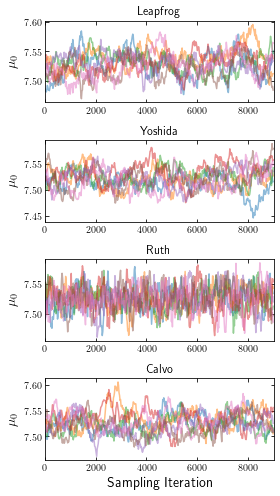

In [45]:
# Trace
r=20

f, axs = plt.subplots(4, 1, figsize=(4, 7))



xslf = results[name][integrators[0]]['L'][0][5][:,1000:]
xsyo = results[name][integrators[1]]['L'][0][5][:,1000:]
xsruth = results[name][integrators[2]]['L'][0][5][:,1000:]
xscal = results[name][integrators[3]]['L'][0][5][:,1000:]

for i in range(N_chains):
    axs[0].plot(range(0,xslf.shape[1],r), xslf[i,::r,0], alpha=0.5)
axs[0].set_ylabel(f'$\mu_0$', fontsize=14)
axs[0].set_xlim(0,xslf.shape[1])
# axs[0].set_ylim(-0.05,0.05)
axs[0].set_title('Leapfrog')
# axs[0].tick_params(axis="x",direction="in", labelbottom=False)  

for i in range(N_chains):
    axs[1].plot(range(0,xsyo.shape[1],r), xsyo[i,::r,0], alpha=0.5)
axs[1].set_ylabel(f'$\mu_0$', fontsize=14)
axs[1].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[1].set_title('Yoshida')
# axs[0].tick_params(axis="x",direction="in", labelbottom=False)


for i in range(N_chains):
    axs[3].plot(range(0,xscal.shape[1],r), xscal[i,::r,0], alpha=0.5)
axs[3].set_ylabel(f'$\mu_0$', fontsize=14)
axs[3].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[3].set_title('Calvo')
# axs[2].set_xlabel('Sampling Iteration')

for i in range(N_chains):
    axs[2].plot(range(0,xsruth.shape[1],r), xsruth[i,::r,0], alpha=0.5)
axs[2].set_ylabel(f'$\mu_0$', fontsize=14)
axs[2].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[2].set_title('Ruth')
axs[3].set_xlabel('Sampling Iteration', fontsize=14)

plt.tight_layout()
f.savefig('gauss_trace.pdf')

# HLR

In [20]:
name='HLR'
latex = r'Hierarchical Logistic Regression'

if name not in results.keys():
    results[name] = {}

In [11]:
# Read data
data = np.loadtxt('UCI_processed_data.txt')

In [12]:
# Initialize Distribution
dist = HierarchicalBayesianLogisticRegression(300)

In [21]:
init_x = np.random.randn(302)
init_x[-1] = 100
nargs=302

In [14]:
for sampler in integrators:
    
    print(name, sampler)
    results[name][sampler]={}
    
    
    samples, times, acc = run_dt(data, dist, 
                                 M=0.1*np.identity(302),
                                 n_args=nargs, steps=10**4,
                                 N_chains=N_chains,
                                 init_x=init_x,
                                 L=5, 
                                 dt=dts, 
                                 prop=sampler, 
                                 verbose=True
                                )
    results[name][sampler]['dt'] = (samples, times, acc)
    
    
    samples, times, acc = run_L(data, dist,
                                M=0.1*np.identity(302),
                                n_args=nargs, steps=10**4,
                                N_chains=N_chains,
                                init_x=init_x,
                                Ls=Ls,
                                dt=1e-4,
                                prop=sampler, 
                                verbose=True
                               )
    results[name][sampler]['L'] = (samples, times, acc)


HLR leapfrog
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

1e-05


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

0.0001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/9999 [00:00<20:30,  8

0.001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

0.01


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


Running: [3 4 5 6 7]
3


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/9999 [00:00<21:44,  7.66it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / s

4


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

5


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


6


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

7


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

HLR yoshida
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/9999 [00:00<21:50,  7.63it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distribut

1e-05


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

0.0001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


0.001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

0.01


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

Running: [3 4 5 6 7]
3


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


4


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


5


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/9999 [00:00<16:52,  9.87it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.e

6


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

7


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


HLR ruth
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


1e-05


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


0.0001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


0.001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


0.01


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

Running: [3 4 5 6 7]
3


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


4


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


5


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

6


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


7


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

HLR calvo
Running: [1e-06, 1e-05, 0.0001, 0.001, 0.01]
1e-06


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


1e-05


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

0.0001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

0.001


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

0.01


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

Running: [3 4 5 6 7]
3


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


4


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/9999 [00:00<25:40,  6

5


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountere

6


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:

7


  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/9999 [00:00<?, ?it/s]/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/maho/git/symHMC/distributions.py:137: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq


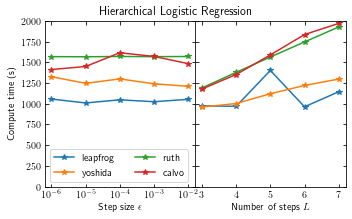

In [22]:
ylim = (0,2000)

f = plt.figure(figsize=(5.,3.))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ax1.semilogx(list(results[name][sampler]['dt'][1].keys()),
                 list(results[name][sampler]['dt'][1].values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Compute time (s)')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][1].keys()))
ax1.legend(ncol=2)


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ax2.plot(list(results[name][sampler]['L'][1].keys()),
             list(results[name][sampler]['L'][1].values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][1].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex, y=1.0)

plt.tight_layout()
f.savefig(imdir+name+'_time.pdf')

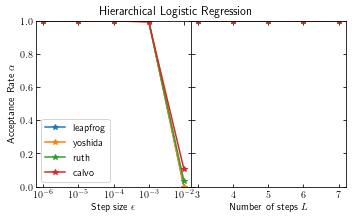

In [23]:
ylim = (0, 1)

f = plt.figure(figsize=(5.,3.))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ax1.semilogx(list(results[name][sampler]['dt'][2].keys()),
                 list(results[name][sampler]['dt'][2].values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Acceptance Rate $\alpha$')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][2].keys()))
ax1.legend(ncol=1, loc=3)


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ax2.plot(list(results[name][sampler]['L'][2].keys()),
             list(results[name][sampler]['L'][2].values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
# ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][2].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex, y=1.)

plt.tight_layout()
f.savefig(imdir+name+'_acc.pdf')

/Users/maho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/maho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


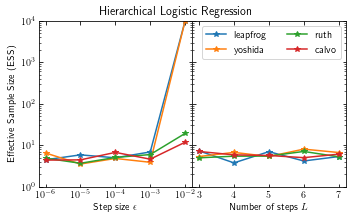

In [22]:
ylim = (1, 10000)

f = plt.figure(figsize=(5.,3.))
gs = mpl.gridspec.GridSpec(1,2, wspace=0)

ax1 = f.add_subplot(gs[0,0])

for sampler in integrators:
    ESS = average_ess(results[name][sampler]['dt'][0])
    ax1.loglog(list(ESS.keys()),
                 list(ESS.values()), '-*', label=sampler)

ax1.set_xlabel(r'Step size $\epsilon$')
ax1.set_ylabel(r'Effective Sample Size (ESS)')
ax1.set_ylim(*ylim)
ax1.set_xticks(list(results[name][sampler]['dt'][2].keys()))
# ax1.legend()


ax2 = f.add_subplot(gs[0,1])

for sampler in integrators:
    ESS = average_ess(results[name][sampler]['L'][0])
    ax2.semilogy(list(ESS.keys()),
                 list(ESS.values()), '-*', label=sampler)

ax2.set_xlabel(r'Number of steps $L$')
ax2.set_ylim(*ylim)
ax2.legend(ncol=2)
ax2.set_xticks(list(results[name][sampler]['L'][2].keys()))
ax2.yaxis.set_major_formatter(plt.NullFormatter())

f.suptitle(latex, y=1.)

plt.tight_layout()
f.savefig(imdir+name+'_ess.pdf')

<Figure size 720x720 with 0 Axes>

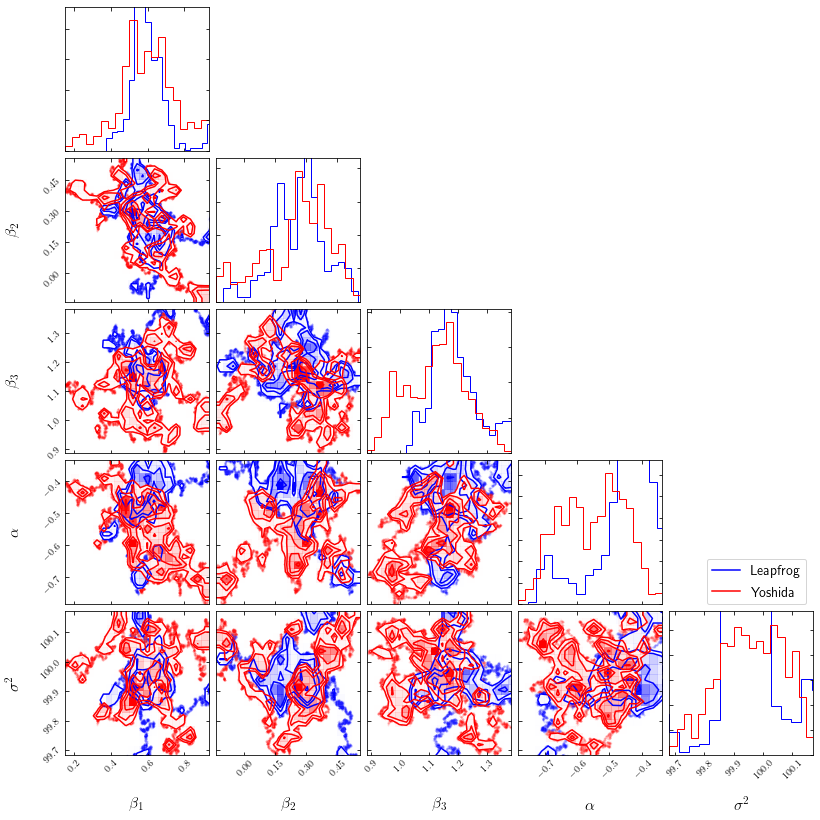

In [19]:
f = plt.figure(figsize=(10.,10.))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0)

sel = [1,2,3,-2,-1]
# Corner plot

cs = ['b','r','g','y']
labels = np.array(['$\\beta_'+str(i)+r'$' for i in range(nargs-2)] + 
                  ['$\\alpha$', '$\\sigma^2$'])
# print(labels)
data = results[name][integrators[0]]['L'][0][5][:,1000:].reshape(-1,nargs)
# data = data[np.all(np.abs(data)<10, axis=1)]
f = corner.corner(data[:,sel], 
                  labels=labels[sel],
                  color=cs[0], truth_color='k',
                  label_kwargs={'fontsize':16})
i=0
for sampler in integrators[1:2]:
    i+=1
    data = results[name][sampler]['L'][0][5][:,1000:].reshape(-1,nargs)
#     data = data[np.all(np.abs(data)<10, axis=1)]
    corner.corner(data[:,sel], 
                  fig=f, color=cs[i])
    

b = mlines.Line2D([], [], color='blue', label='Leapfrog')
r = mlines.Line2D([], [], color='red', label='Yoshida')
# b = mlines.Line2D([], [], color='green', label='Calvo')
# t = mlines.Line2D([], [], marker='.',color='k', label='truth')

plt.legend(handles=[b,r], fontsize=14,
           bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig(imdir+name+'_cornerLY.pdf')

<Figure size 720x720 with 0 Axes>

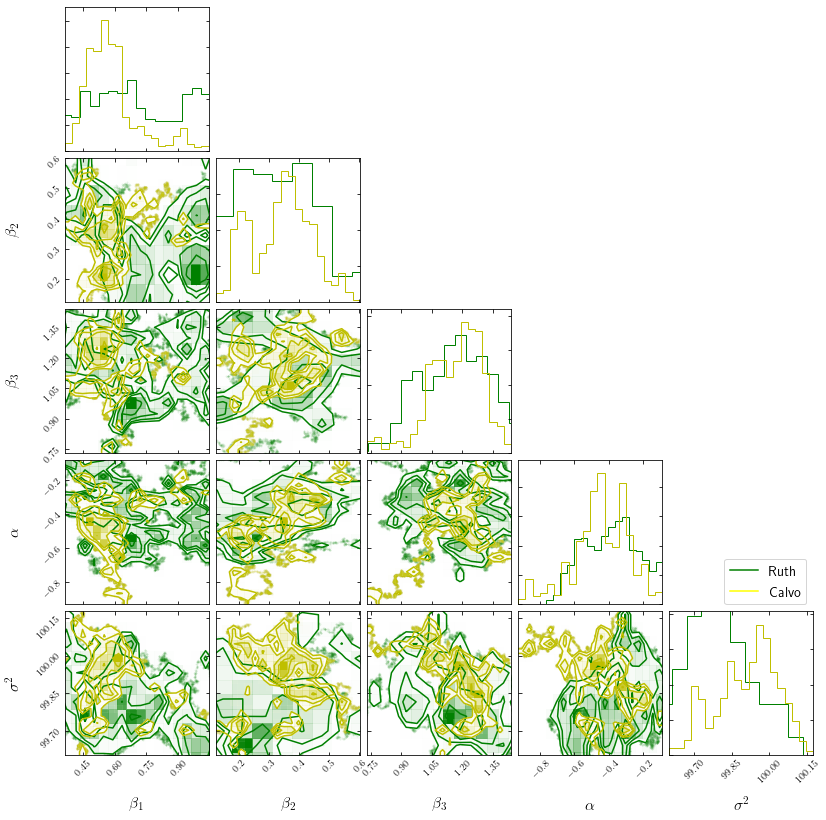

In [102]:
f = plt.figure(figsize=(10.,10.))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0)

sel = [1,2,3,-2,-1]
# Corner plot

cs = ['b','r','g','y']
labels = np.array(['$\\beta_'+str(i)+r'$' for i in range(nargs-2)] + 
                  ['$\\alpha$', '$\\sigma^2$'])
# print(labels)
data = results[name][integrators[2]]['L'][0][5][:,1000:].reshape(-1,nargs)
# data = data[np.all(np.abs(data)<10, axis=1)]
f = corner.corner(data[:,sel], 
                  labels=labels[sel],
                  color='g', truth_color='k',
                  label_kwargs={'fontsize':16})

for sampler in integrators[3:4]:
    data = results[name][sampler]['L'][0][5][:,1000:].reshape(-1,nargs)
#     data = data[np.all(np.abs(data)<10, axis=1)]
    corner.corner(data[:,sel], 
                  fig=f, color='y')
    

# b = mlines.Line2D([], [], color='blue', label='Leapfrog')
# r = mlines.Line2D([], [], color='red', label='Yoshida')
g = mlines.Line2D([], [], color='green', label='Ruth')
y = mlines.Line2D([], [], color='yellow', label='Calvo')
# t = mlines.Line2D([], [], marker='.',color='k', label='truth')

plt.legend(handles=[g,y], fontsize=14,
           bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

f.savefig(imdir+name+'_cornerRC.pdf')

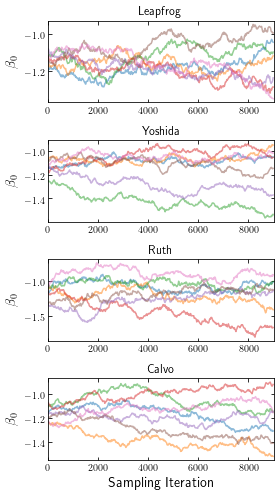

In [43]:
# Trace
r=20

f, axs = plt.subplots(4, 1, figsize=(4, 7))



xslf = results[name][integrators[0]]['L'][0][5][:,1000:]
xsyo = results[name][integrators[1]]['L'][0][5][:,1000:]
xsruth = results[name][integrators[2]]['L'][0][5][:,1000:]
xscal = results[name][integrators[3]]['L'][0][5][:,1000:]

for i in range(N_chains):
    axs[0].plot(range(0,xslf.shape[1],r), xslf[i,::r,0], alpha=0.5)
axs[0].set_ylabel(r'$\beta_0$', fontsize=14)
axs[0].set_xlim(0,xslf.shape[1])
# axs[0].set_ylim(-0.05,0.05)
axs[0].set_title('Leapfrog')
# axs[0].tick_params(axis="x",direction="in", labelbottom=False)  

for i in range(N_chains):
    axs[1].plot(range(0,xsyo.shape[1],r), xsyo[i,::r,0], alpha=0.5)
axs[1].set_ylabel(r'$\beta_0$', fontsize=14)
axs[1].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[1].set_title('Yoshida')
# axs[0].tick_params(axis="x",direction="in", labelbottom=False)


for i in range(N_chains):
    axs[3].plot(range(0,xscal.shape[1],r), xscal[i,::r,0], alpha=0.5)
axs[3].set_ylabel(r'$\beta_0$', fontsize=14)
axs[3].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[3].set_title('Calvo')
# axs[2].set_xlabel('Sampling Iteration')

for i in range(N_chains):
    axs[2].plot(range(0,xsruth.shape[1],r), xsruth[i,::r,0], alpha=0.5)
axs[2].set_ylabel(r'$\beta_0$', fontsize=14)
axs[2].set_xlim(0,xslf.shape[1])
# axs[1].set_ylim(-0.05,0.05)
axs[2].set_title('Ruth')
axs[3].set_xlabel('Sampling Iteration', fontsize=14)

plt.tight_layout()
f.savefig('hlr_trace.pdf')

# Archive

## Uni

In [ ]:
results_uni_dt_lp, times_uni_dt_lp, acc_uni_dt_lp = run_dt(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5],
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='leapfrog'
)

In [ ]:
results_uni_L_lp, times_uni_L_lp, acc_uni_L_lp = run_L(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5], 
    prop='leapfrog'
)

In [ ]:
results_uni_dt_ys, times_uni_dt_ys, acc_uni_dt_ys = run_dt(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5],
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='yoshida'
)

In [ ]:
results_uni_L_ys, times_uni_L_ys, acc_uni_L_ys = run_L(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5], 
    prop='yoshida'
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_uni_dt_lp.keys())), list(times_uni_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_uni_dt_ys.keys())), list(times_uni_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_uni_L_lp.keys()), list(times_uni_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_uni_L_ys.keys()), list(times_uni_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
# mpl.rcParams.update({'font.size': 15})

In [ ]:
average_ess(results_uni_dt_lp)

In [ ]:
average_ess(results_uni_dt_ys)

In [ ]:
average_ess(results_uni_L_lp) 

In [ ]:
average_ess(results_uni_L_ys) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_uni_dt_lp.keys())), list(acc_uni_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_uni_dt_ys.keys())), list(acc_uni_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_uni_L_lp.keys()), list(acc_uni_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_uni_L_ys.keys()), list(acc_uni_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
mpl.rc('font', size=19)

## Multivariate Gausss

In [ ]:
results_ind_dt_lp, times_ind_dt_lp, acc_ind_dt_lp = run_dt(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=3,#N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   L=5, 
   dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
   prop='leapfrog'
)


In [ ]:
def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size_on_seperate_dimensions(xs[c]))
        ess[p] = np.mean(temp)
    return ess

In [ ]:
average_ess(results_ind_dt_lp)

In [ ]:
results_ind_L_lp, times_ind_L_lp, acc_ind_L_lp = run_L(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   prop='leapfrog'
)

In [ ]:
average_ess(results_ind_L_lp)

In [ ]:
results_ind_dt_ys, times_ind_dt_ys, acc_ind_dt_ys = run_dt(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   L=5, 
   dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
   prop='yoshida'
)

In [ ]:
average_ess(results_ind_dt_ys)

In [ ]:
results_ind_L_ys, times_ind_L_ys, acc_ind_L_ys = run_L(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   prop='yoshida'
)

In [ ]:
import matplotlib

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_ind_dt_lp.keys())), list(times_ind_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_ind_dt_ys.keys())), list(times_ind_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_ind_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_ind_L_lp.keys()), list(times_ind_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_ind_L_ys.keys()), list(times_ind_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_ind_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 40})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_ind_dt_lp.keys())), list(acc_ind_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_ind_dt_ys.keys())), list(acc_ind_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_ind_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_ind_L_lp.keys()), list(acc_ind_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_ind_L_ys.keys()), list(acc_ind_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_ind_L_ys.keys()))

## HLR

In [ ]:
results_hlr_dt_lp, times_hlr_dt_lp, acc_hlr_dt_lp = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='leapfrog'
)

In [ ]:
times_uni_dt_lp

In [ ]:
results_hlr_dt_ys, times_hlr_dt_ys, acc_hlr_dt_ys = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='yoshida'
)

In [ ]:
results_hlr_dt_rt, times_hlr_dt_rt, acc_hlr_dt_rt = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='ruth'
)

In [ ]:
results_hlr_dt_ca, times_hlr_dt_ca, acc_hlr_dt_ca = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='calvo'
)

In [ ]:
results_hlr_L_lp, times_hlr_L_lp, acc_hlr_L_lp = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='leapfrog'
)

In [ ]:
results_hlr_L_ys, times_hlr_L_ys, acc_hlr_L_ys = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='yoshida'
)

In [ ]:
results_hlr_L_rt, times_hlr_L_rt, acc_hlr_L_rt = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='ruth'
)

In [ ]:
results_hlr_L_ca, times_hlr_L_ca, acc_hlr_L_ca = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='calvo'
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_hlr_dt_lp.keys())), list(times_hlr_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_hlr_dt_ys.keys())), list(times_hlr_dt_ys.values()), '-*', label='Yoshida')
ax1.plot(np.log10(list(times_hlr_dt_rt.keys())), list(times_hlr_dt_rt.values()), '-*', label='Ruth')
ax1.plot(np.log10(list(times_hlr_dt_ca.keys())), list(times_hlr_dt_ca.values()), '-*', label='Calvo')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_hlr_L_lp.keys()), list(times_hlr_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_hlr_L_ys.keys()), list(times_hlr_L_ys.values()), '-*', label='Yoshida')
ax2.plot(list(times_hlr_L_rt.keys()), list(times_hlr_L_rt.values()), '-*', label='Ruth')
ax2.plot(list(times_hlr_L_ca.keys()), list(times_hlr_L_ca.values()), '-*', label='Calvo')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_hlr_dt_lp.keys())), list(acc_hlr_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_hlr_dt_ys.keys())), list(acc_hlr_dt_ys.values()), '-*', label='Yoshida')
ax1.plot(np.log10(list(acc_hlr_dt_rt.keys())), list(acc_hlr_dt_rt.values()), '-*', label='Ruth')
ax1.plot(np.log10(list(acc_hlr_dt_ca.keys())), list(acc_hlr_dt_ca.values()), '-*', label='Calvo')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_hlr_L_lp.keys()), list(acc_hlr_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_hlr_L_ys.keys()), list(acc_hlr_L_ys.values()), '-*', label='Yoshida')
ax2.plot(list(acc_hlr_L_rt.keys()), list(acc_hlr_L_rt.values()), '-*', label='Ruth')
ax2.plot(list(acc_hlr_L_ca.keys()), list(acc_hlr_L_lpca.values()), '-*', label='Calvo')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rc('font', size=19)

In [ ]:
average_ess(results_hlr_dt_lp)

In [ ]:
average_ess(results_hlr_dt_ys)

In [ ]:
average_ess(results_hlr_dt_rt)

In [ ]:
average_ess(results_hlr_dt_ca)

In [ ]:
average_ess(results_hlr_L_lp)

In [ ]:
results_hlr_L_ca

# Scratch